### Multilayer Perceptron (FF net w/ gradient descent)


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [4]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


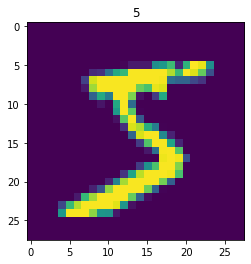

In [5]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [6]:
def evaluator(y_test, y_pred, from_torch=False):
    # define functions for the confision matrix, accuracy, precision, recall and f1

    def confusion_matrix(y_test, y_pred):
      cm = torch.zeros(2, 2)
      for i in range(2):
          for j in range(2):
              cm[i, j] = torch.sum((y_test == i) & (y_pred == j))
      return cm

    def confusion_matrix_from_torch(y_test, y_pred):
      print(y_test, y_pred)
    
    def accuracy(y_test, y_pred):
      cm = confusion_matrix(y_test, y_pred)
      acc = torch.sum(torch.diag(cm))/torch.sum(cm)
      return acc
        
    def precision(y_test, y_pred):
      cm = confusion_matrix(y_test, y_pred)
      tp = cm[1, 1]
      fp = cm[0, 1]
      return tp/(tp+fp)

    def recall(y_test, y_pred):
      cm = confusion_matrix(y_test, y_pred)
      tp = cm[1, 1]
      fn = cm[1, 0]
      return tp/(tp+fn)

    def f1(y_test, y_pred):
      prec = precision(y_test, y_pred)
      rec = recall(y_test, y_pred)
      f1 = 2*prec*rec/(prec+rec)
      return f1

    # evaluate the model 
    if not from_torch:
      cm = confusion_matrix(y_test, y_pred)
    else:
      cm = confusion_matrix_from_torch(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)
    a  = accuracy(y_test, y_pred)
    p  = precision(y_test, y_pred)
    r  = recall(y_test, y_pred)
    f1 = f1(y_test, y_pred)
    # print the results
    print('Confusion Matrix:\n', cm)
    print('Accuracy: {:.3f}'.format(a))
    print('Precision: {:.3f}'.format(p))
    print('Recall: {:.3f}'.format(r))
    print('F1: {:.3f}'.format(f1))

####################################################################################################

## Part 1

In [8]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        return 1 / (1 + torch.exp(-x))
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0

            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
 
                # 1. forward
                ####################################################################################################
                hidden = self.sigmoid(x_batch @ self.W1)
                output = self.sigmoid(hidden @ self.W2)
                ####################################################################################################
                # 2. error and loss
                ####################################################################################################
                output_error = y_batch - output
                loss += torch.sum(output_error ** 2)
                delta_output = output_error * output * (1 - output)
                delta_hidden = (delta_output @ self.W2.T) * hidden * (1 - hidden)
                ####################################################################################################
                # 3. backward
                ####################################################################################################
                self.W2 += self.learning_rate * (hidden.T @ delta_output)
                self.W1 += self.learning_rate * (x_batch.T @ delta_hidden)
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
     
    def predict(self, x):
        # use the trained weights to predict labels and return the predicted labels
        
        hidden = self.sigmoid(x @ self.W1)
        output = self.sigmoid(hidden @ self.W2)
        return torch.argmax(output, dim=1)

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [9]:

####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))
model = NN(learning_rate=0.01, n_iters=50, batch_size=64, hidden_size=32, device=device)
x = data_dict['x_train'].to(device)
y = data_dict['y_train'].to(device)
x_val = data_dict['x_val'].to(device)
y_val = data_dict['y_val'].to(device)
model.train(x,y,x_val,y_val)

####################################################################################################

epoch 1, loss 38690.0117, train acc 0.672, validation acc 0.689
epoch 2, loss 17180.3984, train acc 0.880, validation acc 0.894
epoch 3, loss 10429.4648, train acc 0.902, validation acc 0.912
epoch 4, loss 8467.1621, train acc 0.912, validation acc 0.920
epoch 5, loss 7536.0674, train acc 0.918, validation acc 0.925
epoch 6, loss 6945.4731, train acc 0.924, validation acc 0.930
epoch 7, loss 6516.0659, train acc 0.928, validation acc 0.933
epoch 8, loss 6178.3604, train acc 0.932, validation acc 0.936
epoch 9, loss 5899.7583, train acc 0.935, validation acc 0.939
epoch 10, loss 5662.8672, train acc 0.937, validation acc 0.940
epoch 11, loss 5457.3232, train acc 0.939, validation acc 0.943
epoch 12, loss 5276.3374, train acc 0.941, validation acc 0.944
epoch 13, loss 5115.0698, train acc 0.943, validation acc 0.945
epoch 14, loss 4969.9419, train acc 0.945, validation acc 0.947
epoch 15, loss 4838.2710, train acc 0.947, validation acc 0.949
epoch 16, loss 4718.0107, train acc 0.948, val

In [12]:
####################################################################################################
#use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator
hidden = model.sigmoid(data_dict['x_test'].to(device) @ model.W1)
output = model.sigmoid(hidden @ model.W2)
y_pred = torch.argmax(output, dim=1)
y_labels = torch.argmax(data_dict['y_test'].to(device), dim=1)


print('accuracy:' )

evaluator(y_labels, y_pred)

####################################################################################################

accuracy:
Confusion Matrix:
 tensor([[ 962.,    0.],
        [   0., 1119.]])
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000


## Part 2

### Model2-1

In [ ]:
####################################################################################################
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='logistic', alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.01, verbose=True)
####################################################################################################

In [ ]:
####################################################################################################
mlp.fit(data_dict['x_train'], data_dict['y_train'])
####################################################################################################

Iteration 1, loss = 3.11138165
Iteration 2, loss = 2.13132235
Iteration 3, loss = 1.58964190
Iteration 4, loss = 1.29892301
Iteration 5, loss = 1.11882426
Iteration 6, loss = 0.99746216
Iteration 7, loss = 0.91087077
Iteration 8, loss = 0.84733159
Iteration 9, loss = 0.79930226
Iteration 10, loss = 0.76151444
Iteration 11, loss = 0.73133137
Iteration 12, loss = 0.70644336
Iteration 13, loss = 0.68530763
Iteration 14, loss = 0.66733438
Iteration 15, loss = 0.65157516
Iteration 16, loss = 0.63782238
Iteration 17, loss = 0.62568641
Iteration 18, loss = 0.61467763
Iteration 19, loss = 0.60451535
Iteration 20, loss = 0.59547539
Iteration 21, loss = 0.58692856
Iteration 22, loss = 0.57907375
Iteration 23, loss = 0.57177122
Iteration 24, loss = 0.56508039
Iteration 25, loss = 0.55864497
Iteration 26, loss = 0.55259098
Iteration 27, loss = 0.54701479
Iteration 28, loss = 0.54161238
Iteration 29, loss = 0.53648306
Iteration 30, loss = 0.53176621
Iteration 31, loss = 0.52707161
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='logistic', hidden_layer_sizes=(15,),
              learning_rate_init=0.01, random_state=1, solver='sgd',
              verbose=True)

In [ ]:
####################################################################################################
from sklearn.metrics import accuracy_score

predictions = mlp.predict(data_dict['x_test'])
accuracy_score(data_dict['y_test'], predictions)
evaluator(data_dict['y_test'], predictions)
####################################################################################################

(10000, 10) torch.Size([10000, 10])
Confusion Matrix:
 tensor([[89560.,   440.],
        [  914.,  9086.]])
Accuracy: 0.986
Precision: 0.954
Recall: 0.909
F1: 0.931


### Model2 - Change hidden layer size


In [ ]:
####################################################################################################
# enter code here to implement Model2-2
#
# only difference is
#      param: hidder_layer_sizes = (32, 32)
#             --> corresponding to 2 hiden layers each with 10 neurons   
mlp = MLPClassifier(hidden_layer_sizes=(32,32), activation='logistic', alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.1, verbose=True)
####################################################################################################

In [ ]:
####################################################################################################
# enter code here to train Model2-2
mlp.fit(data_dict['x_train'], data_dict['y_train'])
####################################################################################################

Iteration 1, loss = 2.78898465
Iteration 2, loss = 1.29733127
Iteration 3, loss = 0.86388761
Iteration 4, loss = 0.68547002
Iteration 5, loss = 0.60716698
Iteration 6, loss = 0.55856221
Iteration 7, loss = 0.52714974
Iteration 8, loss = 0.50220606
Iteration 9, loss = 0.48258993
Iteration 10, loss = 0.46980611
Iteration 11, loss = 0.45839215
Iteration 12, loss = 0.44839663
Iteration 13, loss = 0.44057612
Iteration 14, loss = 0.43028636
Iteration 15, loss = 0.42405097
Iteration 16, loss = 0.41796455
Iteration 17, loss = 0.41438234
Iteration 18, loss = 0.40887143
Iteration 19, loss = 0.40466315
Iteration 20, loss = 0.40161190
Iteration 21, loss = 0.39749369
Iteration 22, loss = 0.39158183


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 10),
              learning_rate_init=0.1, random_state=1, solver='sgd',
              verbose=True)

In [ ]:
####################################################################################################
# enter code here to evaluate Model2-2
from sklearn.metrics import accuracy_score

predictions = mlp.predict(data_dict['x_test'])
accuracy_score(data_dict['y_test'], predictions)
evaluator(data_dict['y_test'], predictions)
####################################################################################################

Confusion Matrix:
 tensor([[89504.,   496.],
        [  777.,  9223.]])
Accuracy: 0.987
Precision: 0.949
Recall: 0.922
F1: 0.935
